In [1]:
import sys; sys.path.insert(0, '..')

import gym
import sys
import torch
import tester
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Javascript

import pytorch_drl.models.ddpg_models as models
from pytorch_drl.utils.exploration import *
from pytorch_drl.algs.ddpg import DDPG
from notebook_utils import plot, mean_filter

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")#
#device = "cpu"
print("Device:", device)

Device: cuda:0


## Create environment

In [4]:
env_name = "Pendulum-v0"
env = gym.make(env_name)
env.seed(0)

state_size =  env.observation_space.shape[0]
action_size = env.action_space.shape[0]

print("State size:", state_size, "\nAction size:", action_size)
print(env.action_space.high, env.action_space.low)

State size: 3 
Action size: 1
[2.] [-2.]


/home/selo/Envs/ml-agent_/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Define networks for different algorithms

In [7]:
tmax = 500
n_episodes = 2_000
seed = 0

## DDPG Test

Test the standard DDPG algorithm

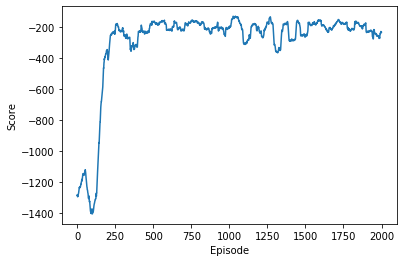

In [9]:
value_net = models.DDPGValueNetwork(state_size, action_size)
policy_net = models.DDPGPolicyNetwork(state_size, action_size)

max_act = env.action_space.high
min_act = env.action_space.low

theta=0.15
sigma=0.2
noise_process = OrnsteinUhlenbeck(x_size=env.action_space.shape, mu=0, 
                                    sigma_init=sigma, sigma_final=sigma,
                                    sigma_horizon=1, theta=theta)

action = env.action_space.sample()
#noise_proc = OrnsteinUhlenbeck(x0=np.zeros_like(action))

lr_val = 1e-3
lr_pol = 1e-4

# init agent:
agent = DDPG(policy_net=policy_net,
             value_net=value_net,
             lr_val=lr_val,
             lr_pol=lr_pol,
             buf_size=int(1e6),
             device=device,
             max_grad_norm=0.5,
             noise_process=noise_process,
             min_act=min_act,
             max_act=max_act,
             learn_every=1,
             warm_up=1e4,
             seed=0)

alg_name = "ddpg_{}".format(env_name)
max_score = -20.
scores = agent.train(env, tmax, n_episodes, alg_name, max_score)
plot(scores, 50)

### 4.1 Trained Agent Demonstration

In [ ]:
agent.test(env, tmax, render=True, n_episodes=5)